In [1]:
import torch
from torch import nn
import math


In [2]:
from src.models.transformer_main import Transformer


## GPT

In [3]:
# arch,
# d_model,
# max_len,
# num_heads,
# num_layers,
# num_classes,
# d_ff,
# dropout,

In [4]:
sentences = ["My name is Ravi", "I live in Bangalore"]
vocab = [sentence.split(" ") for sentence in sentences]
vocab = list(set([word.lower() for sentence in vocab for word in sentence]))
lut = {word: index for index, word in enumerate(vocab)}
sentence_tokens = [
    [lut[word.lower()] for word in sentence.split(" ")] for sentence in sentences
]
token_tensors = torch.tensor(sentence_tokens)

vocab_size = len(lut)


In [5]:
from src.data.gpt_data import GPTDataModule


In [6]:
import hydra
from hydra import initialize, compose

try:
    initialize(version_base="1.3", config_path=".", job_name="all")
except ValueError:
    hydra.core.global_hydra.GlobalHydra.instance().clear()
    initialize(version_base="1.3", config_path=".", job_name="all")

cfg = compose(config_name="config")


In [7]:
datamodule = GPTDataModule(
    path_do_data=f"{cfg.gpt.data}/english.txt",
    batch_size=cfg.gpt.batch_size,
    seq_len=cfg.gpt.seq_len,
)
datamodule.setup()


Token indices sequence length is longer than the specified maximum sequence length for this model (37443 > 512). Running this sequence through the model will result in indexing errors


In [8]:
datamodule.train_dataset[0]


(tensor([ 5219,  1014,  1011,  7570,  2721,   999,  6160,  2000,  1996,  2707,
          1997,  1996,  2203,  1997,  2115,  2607,   999,  2009,  2001,  1037,
          5165,  2551,  2007,  2017,  2035,   999,  2115, 19846,  2057,  2031,
         17332,  2493,  1006,  2012,  1996,  2051,  1997,  3015,  1007,  1999,
          1996,  9345,  1022,  4403,  1015,  2465,  1012,  2261,  2111,  3561,
          1999,  1996,  2433,  3674,  2335,  1996,  2779,  3325,  1997,  2111,
          2003,  1022,  2086,  1006]),
 tensor([ 1014,  1011,  7570,  2721,   999,  6160,  2000,  1996,  2707,  1997,
          1996,  2203,  1997,  2115,  2607,   999,  2009,  2001,  1037,  5165,
          2551,  2007,  2017,  2035,   999,  2115, 19846,  2057,  2031, 17332,
          2493,  1006,  2012,  1996,  2051,  1997,  3015,  1007,  1999,  1996,
          9345,  1022,  4403,  1015,  2465,  1012,  2261,  2111,  3561,  1999,
          1996,  2433,  3674,  2335,  1996,  2779,  3325,  1997,  2111,  2003,
          102

In [9]:
datamodule.train_dataset[0][0].shape

torch.Size([64])

In [10]:
datamodule.tokenizer.vocab_size


30522

In [11]:
gpt = Transformer(
    arch="gpt",
    d_model=cfg.gpt.embed_size,
    max_len=cfg.gpt.seq_len,
    num_heads=cfg.gpt.n_heads,
    num_layers=cfg.gpt.n_layers,
    num_classes=datamodule.tokenizer.vocab_size,
    d_ff=cfg.gpt.inner_ff_size,
    dropout=cfg.gpt.dropout,
    lr=cfg.gpt.lr,
)


In [12]:
# gpt(token_tensors).shape


In [13]:
input_ = datamodule.train_dataset[0][0].unsqueeze(0)
target_ = datamodule.train_dataset[0][1].unsqueeze(0)


In [14]:
pred = gpt(input_)

In [15]:
input_.shape, target_.shape


(torch.Size([1, 64]), torch.Size([1, 64]))

In [16]:
pred.shape


torch.Size([1, 64, 30522])

In [17]:
loss_fn = nn.CrossEntropyLoss()

In [18]:
output_v = pred.view(-1, pred.shape[-1])
target_v = target_.view(-1, 1).squeeze()


In [19]:
output_v.shape, target_v.shape

(torch.Size([64, 30522]), torch.Size([64]))

In [20]:
loss_fn(output_v, target_v)

tensor(10.3263, grad_fn=<NllLossBackward0>)

### BERT

In [21]:
from src.data.bert_data import BertDataModule

In [22]:
import hydra
from hydra import initialize, compose

try:
    initialize(version_base="1.3", config_path=".", job_name="all")
except ValueError:
    hydra.core.global_hydra.GlobalHydra.instance().clear()
    initialize(version_base="1.3", config_path=".", job_name="all")

cfg = compose(config_name="config")


In [23]:
datamodule = BertDataModule(
    seq_len=cfg.bert.seq_len,
    n_vocab=cfg.bert.n_vocab,
    trainpth=f"{cfg.bert.data}/training.txt",
    vocabpth=f"{cfg.bert.data}/vocab.txt",
    batch_size=cfg.bert.batch_size,
)
datamodule.setup()


In [24]:
bert = Transformer(
    arch="bert",
    d_model=cfg.bert.embed_size,
    max_len=cfg.bert.seq_len,
    num_heads=cfg.bert.n_heads,
    num_layers=cfg.bert.n_layers,
    num_classes=cfg.bert.n_vocab,
    d_ff=cfg.bert.inner_ff_size,
    dropout=cfg.bert.dropout,
    lr=cfg.bert.lr,
)


In [25]:
datamodule.dataset[0][0].shape


torch.Size([20])

In [26]:
input_ = datamodule.dataset[0][0].unsqueeze(0)
target_ = datamodule.dataset[0][1].unsqueeze(0)


In [27]:
pred = bert(input_)

In [28]:
pred.shape

torch.Size([1, 20, 40000])

In [29]:
loss_fn = nn.CrossEntropyLoss()

In [30]:
output_v = pred.view(-1, pred.shape[-1])
target_v = target_.view(-1, 1).squeeze()


In [31]:
output_v.shape


torch.Size([20, 40000])

In [32]:
target_v.shape


torch.Size([20])

In [33]:
loss_fn(output_v, target_v)

tensor(10.5967, grad_fn=<NllLossBackward0>)

### VIT

In [9]:
img_size = 28
patch_size = 4
num_patches = img_size // patch_size
max_len = num_patches**2 + 1


In [14]:
vit = Transformer(
    arch="vit",
    img_size=28,
    patch_size=4,
    d_model=768,
    max_len=max_len,
    num_heads=16,
    num_layers=6,
    input_channels=1,
    n_layers=6,
    num_classes=10,
    d_ff=3072,
    dropout=0.1,
)

In [15]:
images = torch.randn(2, 1, 28, 28)

In [16]:
vit(images).shape

torch.Size([2, 10])

In [19]:
images = torch.randn(2, 3, 224, 224)
img_size = 224
patch_size = 16
num_patches = img_size // patch_size
max_len = num_patches**2 + 1
vit = Transformer(
    arch="vit",
    img_size=224,
    patch_size=16,
    d_model=768,
    max_len=max_len,
    num_heads=16,
    num_layers=6,
    input_channels=3,
    n_layers=6,
    num_classes=10,
    d_ff=3072,
    dropout=0.1,
)

vit(images).shape

torch.Size([2, 10])

## VIT TRAIN

In [34]:
from src.data.vit_data import ViTDataModule

In [35]:
import hydra
from hydra import initialize, compose

try:
    initialize(version_base="1.3", config_path=".", job_name="all")
except ValueError:
    hydra.core.global_hydra.GlobalHydra.instance().clear()
    initialize(version_base="1.3", config_path=".", job_name="all")

cfg = compose(config_name="config")


In [36]:
from src.utils.utils import image_transforms

In [37]:
transforms = image_transforms(image_size=cfg.vit.img_size)

In [40]:
datamodule = ViTDataModule(
    train_dir=cfg.vit.train_dir,
    test_dir=cfg.vit.test_dir,
    transform=transforms,
    batch_size=cfg.vit.batch_size,
    num_workers=cfg.vit.n_workers,
)
datamodule.setup()


In [44]:
datamodule.train_data[0][0].shape, datamodule.train_data[0][1]

(torch.Size([3, 224, 224]), 0)

In [45]:
import matplotlib.pyplot as plt


Text(0.5, 1.0, 'pizza')

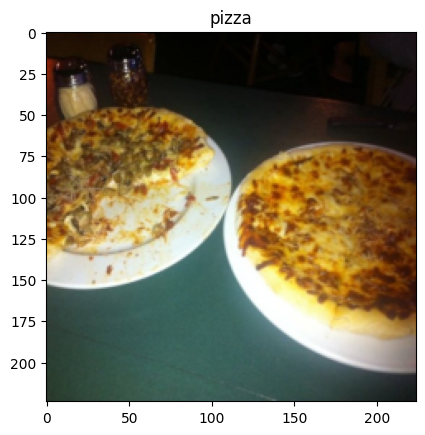

In [47]:
plt.imshow(datamodule.train_data[0][0].permute(1, 2, 0))
plt.title(datamodule.class_names[datamodule.train_data[0][1]])

In [51]:
input_, target_ = next(iter(datamodule.train_dataloader()))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [57]:
num_patches = cfg.vit.img_size // cfg.vit.patch_size
max_len = num_patches**2 + 1
vit = Transformer(
    arch="vit",
    d_model=768,
    max_len=max_len,
    num_heads=6,
    num_layers=6,
    num_classes=10,
    d_ff=3072,
    dropout=0.1,
    lr=cfg.vit.lr,
    patch_size=cfg.vit.patch_size,
    input_channels=cfg.vit.color_channels,
)


In [58]:
pred = vit(input_)


In [59]:
pred.shape


torch.Size([32, 10])

In [60]:
loss_fn = nn.CrossEntropyLoss()


In [61]:
loss_fn(pred, target_)


tensor(2.3507, grad_fn=<NllLossBackward0>)